## NYC Taxi Duration Prediction

### Problem statement

### We are going to build a machine learning model that will predict the total duration of a taxi ride in New York City. Our model will solve a regression problem.

**Customer and Vendor Data:**
* **id** – a unique identifier for each trip  
* **vendor_id** – a unique identifier of the provider (taxi company) associated with the trip record  

**Temporal Features:**
* **pickup_datetime** – the date and time when the trip meter was turned on  
* **dropoff_datetime** – the date and time when the trip meter was turned off  

**Geographical Information:**
* **pickup_longitude** – the longitude at the start of the trip  
* **pickup_latitude** – the latitude at the start of the trip  
* **dropoff_longitude** – the longitude at the end of the trip  
* **dropoff_latitude** – the latitude at the end of the trip  

**Other Features:**
* **passenger_count** – number of passengers in the vehicle (value entered by the driver)  
* **store_and_fwd_flag** – flag indicating whether the trip record was stored in the vehicle memory before sending to the vendor.  
  *Y* – store and forward  
  *N* – do not store and forward the trip  

**Target Variable:**
* **trip_duration** – the duration of the trip in seconds

In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

### Functions and Utility Functions:

In [134]:
def add_osrm_features(df, df_osrm):
    
    """The function that adds 3 columns from the right table to the left table"""
    
    # Merge the tables using the 'id' key 
    merged_df = df.merge(df_osrm[['id', 'total_distance', 'total_travel_time', 'number_of_steps']], on = 'id', how = 'left')
    
    return merged_df 

def add_holiday_features(df, df_holidays):
    
    """ The function that returns an updated table with trip data, including an added column `pickup_holiday` """
    
    # Let's create a list of holiday dates
    df_holidays_list = list(df_holidays['date'].values)
    
    # Let's convert the 'pickup_date' feature to the "str" format
    df['pickup_date_str'] = df['pickup_date'].astype('str')
    
    # Let's create a column 'pickup_holiday', where 1 indicates that the date is in the `df_holidays_list`, and 0 otherwise
    df['pickup_holiday']  = df['pickup_date_str'].apply(lambda x: 1 if x in df_holidays_list else 0)
    
    # Let's remove the 'pickup_date_str' feature
    df = df.drop(axis = 1, columns = 'pickup_date_str')
    
    return df 

def add_datetime_features(df):
    
    """The function that takes a table with trip data as input and returns the same table with three additional columns"""
    
    df['pickup_date'] = df['pickup_datetime'].dt.date
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_day_of_week'] = df['pickup_datetime'].dt.dayofweek
    
    return df

def get_haversine_distance(lat1, lng1, lat2, lng2):
    
    """The function for calculating distance using the Haversine's formula (in kilometers)"""
    
    # Converting angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # The radius of the Earth in kilometers
    EARTH_RADIUS = 6371 
    # Сalculating the shortest distance \( h \) using the Haversine's formula
    lat_delta = lat2 - lat1
    lng_delta = lng2 - lng1
    d = np.sin(lat_delta * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng_delta * 0.5) ** 2
    h = 2 * EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def get_angle_direction(lat1, lng1, lat2, lng2):
    
    """The function to calculate the direction angle of movement (in degrees)"""
    
    # Converting angles to radians
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    # Calculating the direction angle **alpha** using the bearing angle formula
    lng_delta_rad = lng2 - lng1
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    alpha = np.degrees(np.arctan2(y, x))
    return alpha

def add_geographical_features(df):
    
    """The function takes a table with trip data as input and returns an updated table with two added columns"""
    
    # Сonverting our features-coordinates into NumPy-arrays
    lat1 = df['pickup_latitude'].to_numpy()
    lng1 = df['pickup_longitude'].to_numpy()
    lat2 = df['dropoff_latitude'].to_numpy()
    lng2 = df['dropoff_longitude'].to_numpy()
    
    df['haversine_distance'] = pd.Series(get_haversine_distance(lat1, lng1, lat2, lng2))
    df['direction'] = pd.Series(get_angle_direction(lat1, lng1, lat2, lng2))
    
    return df


def add_cluster_features(df, clustering_method):
    
    """The function that labels trip numbers by cluster numbers"""
    
    predictions = clustering_method.labels_

    # Save predictions in DataFrame
    df['geo_cluster'] = predictions
    
    return df

def add_weather_features(df_taxi, weather_df):
    
    """The function adds 5 features from the weather table to the taxi-trips table"""
    
    # We will keep only the features of interest and, in addition, the key features
    weather_df = weather_df[['temperature', 'visibility', 'wind speed', 'precip', 'events', 'date', 'hour']]
    
    df_taxi['pickup_date'] = taxi_data["pickup_date"].astype('str')
    
    # Let's add the features we are interested in to our table on the left using keys
    merged_df = df_taxi.merge(weather_df, left_on = ['pickup_date', 'pickup_hour'], right_on = ['date', 'hour'], how = 'left')
    
    # We will remove key and no longer needed features
    merged_df = merged_df.drop(axis=1, columns=['date', 'hour'])
    
    return merged_df 

def fill_null_weather_data(df_taxi):
    
    """The function for filling missing data with the median value"""
    
    cols_list = ['temperature', 'visibility', 'wind speed', 'precip']
    
    # For each feature from the `cols_list`:
    for col in cols_list:
        
        # We will group the data by the `pickup_date` column and fill the missing values with the median value for each group
        df_taxi[col] = df_taxi[col].fillna(df_taxi.groupby('pickup_date')[col].transform('median')) 
    
    values = {
        'total_distance': df_taxi['total_distance'].median(),
        'total_travel_time': df_taxi['total_travel_time'].median(),
        'number_of_steps': df_taxi['number_of_steps'].median(),
        'events': 'None'
    }
    
    # Filling in missing values according to the specified dictionary
    df_taxi = df_taxi.fillna(values)
    
    return df_taxi

In [135]:
# Look at the data
taxi_data = pd.read_csv("data/train.csv")
print('Train data shape: {}'.format(taxi_data.shape))
taxi_data.head()

Train data shape: (1458644, 11)


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


So, we have data on almost 1.5 million trips and 11 features that describe each of them. 

### EXPLORING THE DATA & FEATURE ENGINEERING

In [136]:
# Convert the features 'pickup_datetime' and 'dropoff_datetime' to the `datetime` data type with the format "year-month-day hour:minute:second"
taxi_data['pickup_datetime'] = pd.to_datetime(taxi_data['pickup_datetime'])
taxi_data['dropoff_datetime'] = pd.to_datetime(taxi_data['dropoff_datetime'])

Let's find out how many missing values are present in the data.

In [137]:
taxi_data.isnull().mean() * 100

id                    0.0
vendor_id             0.0
pickup_datetime       0.0
dropoff_datetime      0.0
passenger_count       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
store_and_fwd_flag    0.0
trip_duration         0.0
dtype: float64

In [138]:
taxi_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   dropoff_datetime    1458644 non-null  datetime64[ns]
 4   passenger_count     1458644 non-null  int64         
 5   pickup_longitude    1458644 non-null  float64       
 6   pickup_latitude     1458644 non-null  float64       
 7   dropoff_longitude   1458644 non-null  float64       
 8   dropoff_latitude    1458644 non-null  float64       
 9   store_and_fwd_flag  1458644 non-null  object        
 10  trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](2), float64(4), int64(3), object(2)
memory usage: 122.4+ MB


#### There are no missing values in the data.

Let's add 3 new features:
* `pickup_date` – the date when the meter was turned on, marking the start of the trip (without time);
* `pickup_hour` – the hour of the day when the meter was turned on;
* `pickup_day_of_week` – the ordinal number of the day of the week (as a number) when the meter was turned on.

In [139]:
taxi_data = add_datetime_features(taxi_data)

In [140]:
# Load the table of public holidays
holiday_data = pd.read_csv('data/holiday_data.csv', sep=';')

In [141]:
# Add a binary feature 'pickup_holiday'
taxi_data = add_holiday_features(taxi_data, holiday_data)

In [142]:
# Load OSRM data
osrm_data = pd.read_csv('data/osrm_data_train.csv')

In [143]:
# Add three new features 'total_distance', 'total_travel_time', 'number_of_steps'
taxi_data = add_osrm_features(taxi_data, osrm_data)

In [144]:
# Add two new 'haversine_distance' and 'direction'
taxi_data = add_geographical_features(taxi_data)

In [145]:
# We create a training dataset from the geographical coordinates of all points
coords = np.hstack((taxi_data[['pickup_latitude', 'pickup_longitude']],
                    taxi_data[['dropoff_latitude', 'dropoff_longitude']]))

# Training the clustering algorithm
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

KMeans(n_clusters=10, random_state=42)

In [146]:
# Add a feature indicating cluster membership 'geo_cluster'
taxi_data = add_cluster_features(taxi_data, kmeans)

In [147]:
# Add 5 new weather-related features by date
weather_data = pd.read_csv('data/weather_data.csv')
taxi_data = add_weather_features(taxi_data, weather_data)

In [148]:
# Let's add 5 new weather-related features by date
taxi_data = fill_null_weather_data(taxi_data)

Let's identify obvious outliers in the target variable—the trip duration.  

The easiest way is to detect excessively long trips. Let's agree that trips lasting more than 24 hours will be considered outliers.  

It is slightly more complicated to analyze trips with extremely short durations. These include actual short-distance trips, trips that were canceled a second after the meter started, as well as "teleportations"—cases where a vehicle moves a long distance in just a few seconds.  
Let's agree that we will consider only the last group as outliers.  

We can use information about the shortest possible distance a taxi can travel. The average speed of a car on the shortest route can be calculated as follows:  
$$avg\_speed= \frac{total\_distance}{1000*trip\_duration}*3600$$  

If we plot a scatter plot of the average speed of the vehicles, we will observe the following pattern:


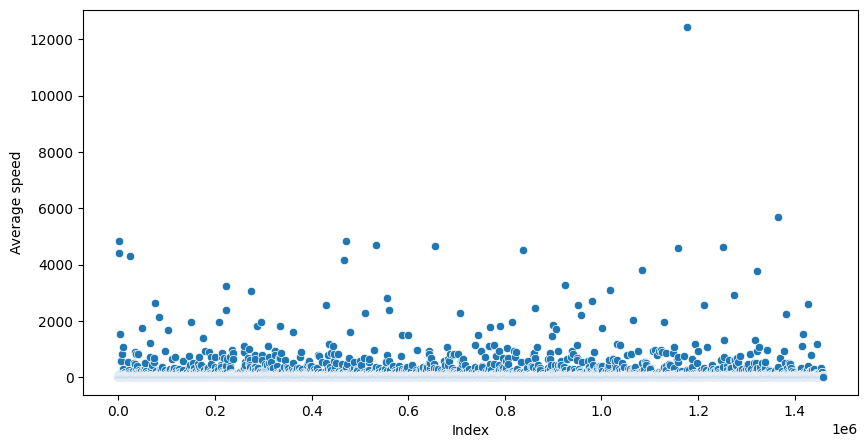

In [149]:
avg_speed = taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
ax.set_xlabel('Index')
ax.set_ylabel('Average speed');

This is exactly where we see that we have "teleportation trips," with an average speed exceeding 1000 km/h. There's even one with an average speed of over 12,000 km/h!  

Let's agree that the maximum average speed taxi drivers can reach will be 300 km/h.


In [150]:
# We will keep only those trips where "total_distance" does not exceed 24 h and the average speed does not exceed 300 km/h
taxi_data_new = taxi_data[(taxi_data['trip_duration'] <= 24*60*60)&(taxi_data['total_distance'] / taxi_data['trip_duration'] * 3.6 < 300)]

# Let's update of the table numeration
taxi_data_new = taxi_data_new.reset_index(drop=True)

print(f'Total number of detected outliers: {taxi_data.shape[0] - taxi_data_new.shape[0]}')

Total number of detected outliers: 411


#### Since the main quality metric for solving the given task will be RMSLE (Root Mean Squared Log Error), which is calculated based on the target variable in a logarithmic scale, it is reasonable to logarithmize the trip duration feature beforehand and consider its logarithm as the target variable during analysis:  
$$trip\_duration\_log = log(trip\_duration+1),$$  
#### where `log` denotes the natural logarithm.

In [151]:
taxi_data_new["trip_duration_log"] = np.log(taxi_data_new["trip_duration"] + 1)
display(taxi_data_new)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,...,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None,6.658011
1458229,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,...,11.0,6.049836,25.342196,6,7.2,2.8,18.5,8.1,Rain,6.486161
1458230,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,...,10.0,7.824606,-150.788492,9,18.3,16.1,0.0,0.0,None,6.639876
1458231,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,...,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None,5.924256


### DATA VISUALIZATION

We check the target feature `'trip_duration_log'` for normality using the D’Agostino test, but first, let’s plot a histogram and a boxplot of the target variable distribution.

Statistic: 138350.17
P-value: 0.00
❌ The distribution is not normal (we reject H₀)


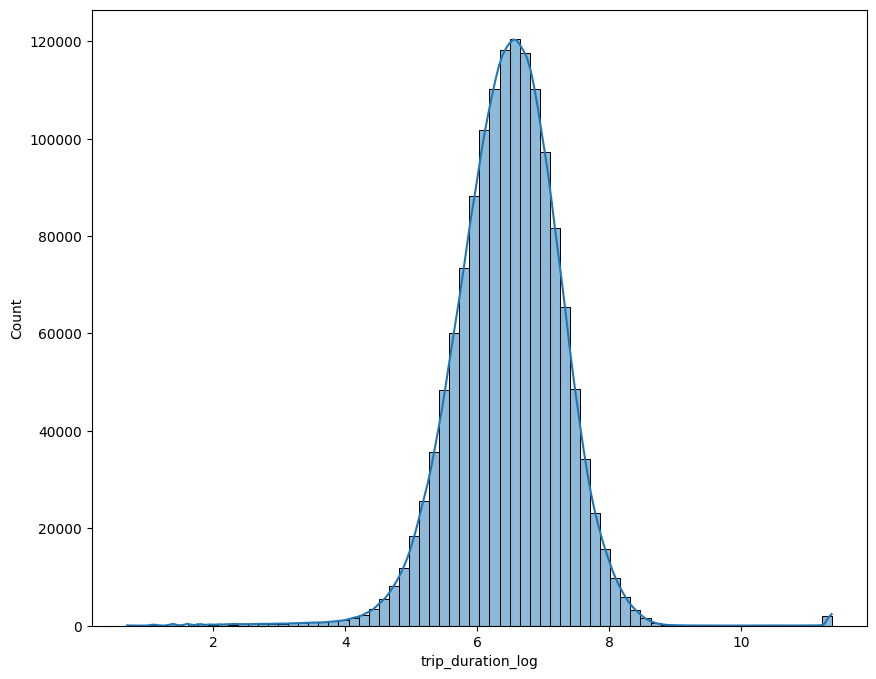

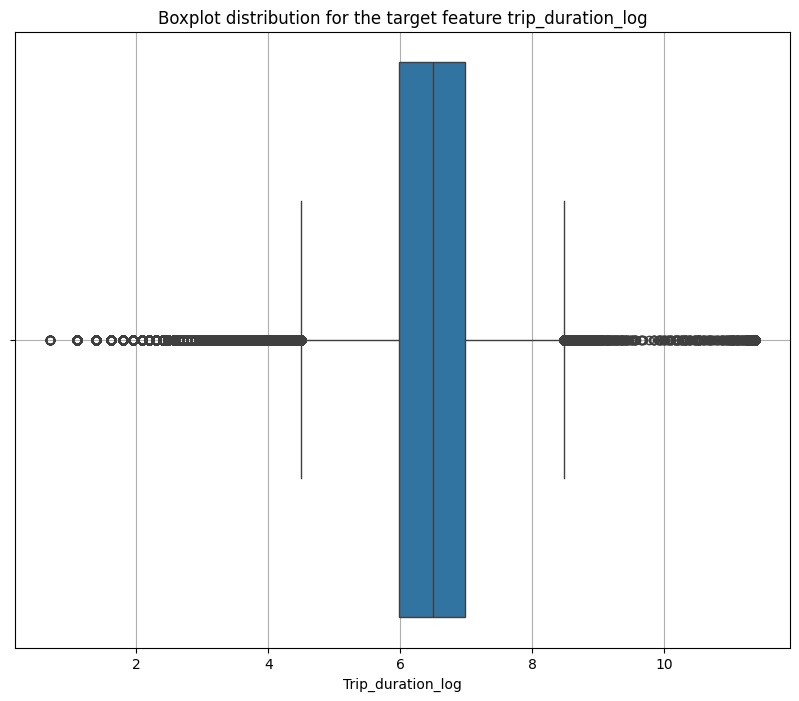

In [152]:
# Set the histogram parameters
fig = plt.figure(figsize=(10, 8))
sns.histplot(
    data=taxi_data_new,
    x='trip_duration_log',
    bins=70,
    kde=True,
);

fig = plt.figure(figsize=(10, 8))
boxplot = sns.boxplot(
    data=taxi_data_new,
    x='trip_duration_log',
    orient='h',
    width=0.9
)
boxplot.set_title('Boxplot distribution for the target feature trip_duration_log');
boxplot.set_xlabel('Trip_duration_log');
boxplot.grid()

from scipy.stats import normaltest
import numpy as np

#  Checking the target feature `'trip_duration_log'` for normality using the D’Agostino test at a significance level of 0.05
statistic, p_value = normaltest(taxi_data_new['trip_duration_log'])

print(f"Statistic: {statistic:.2f}")
print(f"P-value: {p_value:.2f}")

if p_value < 0.05:
    print("❌ The distribution is not normal (we reject H₀)")
else:
    print("✅ The distribution may be normal (we do not reject H₀))")


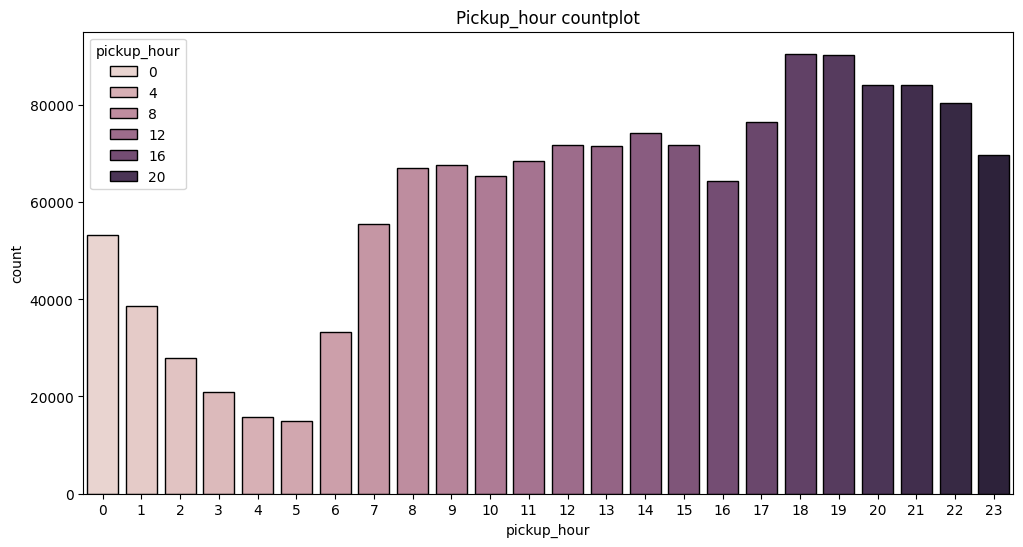

In [153]:
plt.figure(figsize=(12, 6))
countplot = sns.countplot(x="pickup_hour", hue="pickup_hour", data=taxi_data_new, edgecolor="black")
countplot.set_title('Pickup_hour countplot');
plt.show()

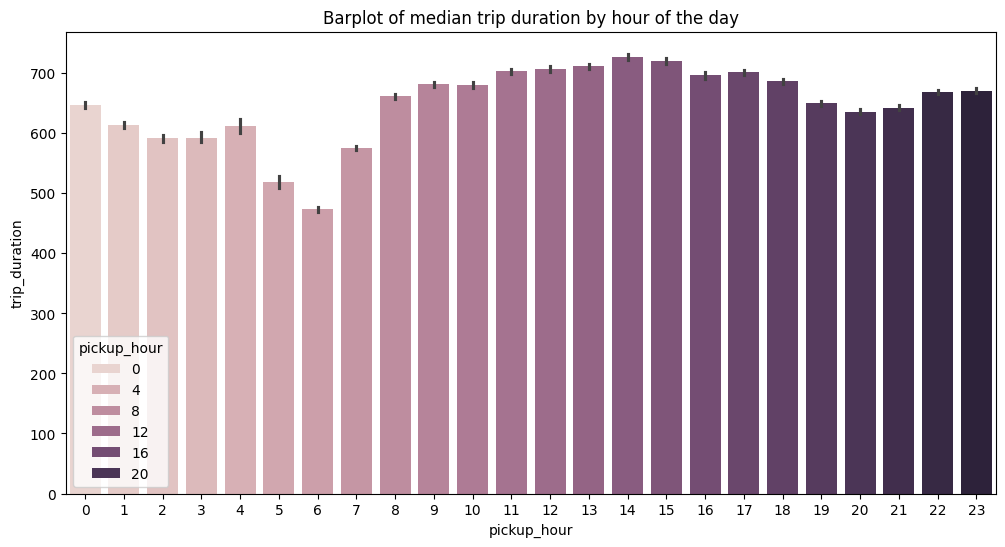

In [154]:
fig = plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=taxi_data_new,
    x='pickup_hour',
    y='trip_duration',
    hue='pickup_hour',
    estimator='median'
)
barplot.set_title('Barplot of median trip duration by hour of the day');

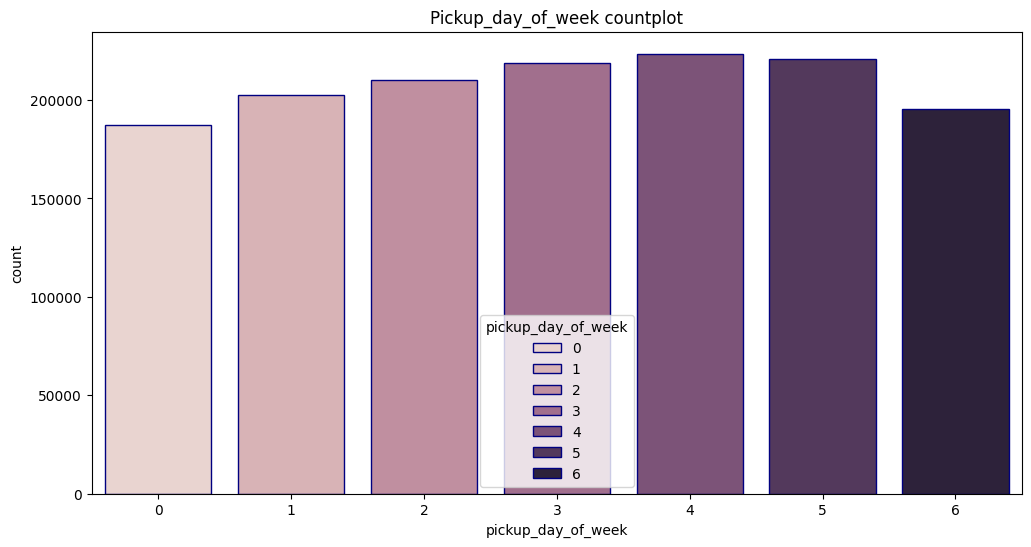

In [155]:
plt.figure(figsize=(12, 6))
countplot = sns.countplot(x="pickup_day_of_week", hue="pickup_day_of_week", data=taxi_data_new, edgecolor="navy")
countplot.set_title('Pickup_day_of_week countplot');
plt.show()

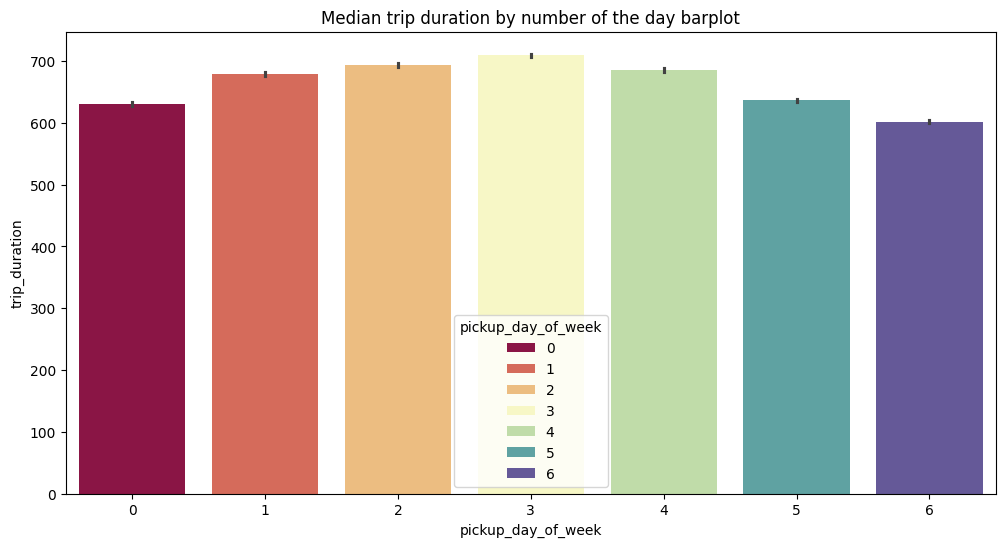

In [156]:
fig = plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=taxi_data_new,
    x='pickup_day_of_week',
    y='trip_duration',
    hue='pickup_day_of_week',
    estimator='median',
    palette='Spectral'
)
barplot.set_title('Median trip duration by number of the day barplot');

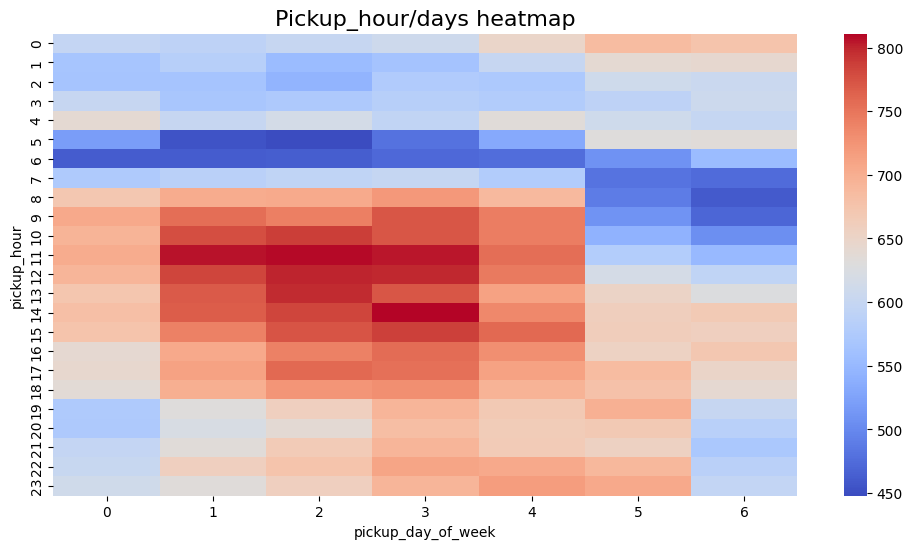

In [157]:
pickup_hour_days_df = taxi_data_new.groupby(['pickup_hour', 'pickup_day_of_week'])['trip_duration'].median()

fig = plt.figure(figsize=(12, 6))
heatmap = sns.heatmap(data=pickup_hour_days_df.unstack(), cmap='coolwarm')
heatmap.set_title('Pickup_hour/days heatmap', fontsize=16);

Conclusions:
* Taxis are ordered least frequently between 00:00 and 05:00.
* The maximum median duration of taxi rides is observed between 13:00 and 18:00.
* Friday is the day with the highest number of trips.
* On Sunday, the median trip duration is the shortest.
* The longest trips (in terms of median duration) occur from Monday to Friday between 8 AM and 6 PM.
* The highest median trip duration was observed on Thursday at 2 PM.

### Feature selection and transformation

##### The feature **"id"** is unique for each trip and does not provide useful information for predicting its duration. The feature **"dropoff_datetime"** causes data leakage, so we will remove it. Previously, we extracted all the necessary information from the trip start date (features **'pickup_datetime'** and **'pickup_date'**), so we can now drop these features as well, since they are no longer needed.

In [158]:
train_data = taxi_data_new.copy()
drop_columns = ['id', 'dropoff_datetime', 'pickup_datetime', 'pickup_date']
train_data = train_data.drop(drop_columns, axis=1)
print('Shape of data: {}'.format(train_data.shape))

Shape of data: (1458233, 23)


In [159]:
# Let's encode the binary features "vendor_id" and "store_and_fwd_flag" using LabelEncoder()
le = LabelEncoder()
train_data["vendor_id"] = le.fit_transform(train_data["vendor_id"])
train_data["store_and_fwd_flag"] = le.fit_transform(train_data["store_and_fwd_flag"])
train_data

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_hour,pickup_day_of_week,...,number_of_steps,haversine_distance,direction,geo_cluster,temperature,visibility,wind speed,precip,events,trip_duration_log
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,455,17,0,...,5.0,1.498521,99.970196,6,4.4,8.0,27.8,0.3,None,6.122493
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,663,0,6,...,6.0,1.805507,-117.153768,9,28.9,16.1,7.4,0.0,None,6.498282
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,2124,11,1,...,16.0,6.385098,-159.680165,9,-6.7,16.1,24.1,0.0,None,7.661527
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,429,19,2,...,4.0,1.485498,-172.737700,9,7.2,16.1,25.9,0.0,None,6.063785
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,435,13,5,...,5.0,1.188588,179.473585,6,9.4,16.1,9.3,0.0,None,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1458228,1,4,-73.982201,40.745522,-73.994911,40.740170,0,778,13,4,...,8.0,1.225080,-119.059338,0,7.8,16.1,11.1,0.0,None,6.658011
1458229,0,1,-74.000946,40.747379,-73.970184,40.796547,0,655,7,6,...,11.0,6.049836,25.342196,6,7.2,2.8,18.5,8.1,Rain,6.486161
1458230,1,1,-73.959129,40.768799,-74.004433,40.707371,0,764,6,4,...,10.0,7.824606,-150.788492,9,18.3,16.1,0.0,0.0,None,6.639876
1458231,0,1,-73.982079,40.749062,-73.974632,40.757107,0,373,15,1,...,7.0,1.092564,35.033294,0,-2.8,16.1,9.3,0.0,None,5.924256


#### The following three features (pickup_day_of_week, geo_cluster, events) are nominal. OneHotEncoder() is a great choice for them.

In [160]:
one_hot_encoder_cols = ['pickup_day_of_week', 'geo_cluster', 'events']
# Declare the encoder
one_hot_encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
# We train and immediately apply the transformation to the dataset, then convert the result into an array
data_onehot_array = one_hot_encoder.fit_transform(train_data[one_hot_encoder_cols]).toarray()
# We obtain the encoded column names
column_names = one_hot_encoder.get_feature_names_out(one_hot_encoder_cols)
# Creating a DataFrame from the encoded features
data_onehot = pd.DataFrame(data_onehot_array, columns=column_names)

# Let's add the encoded columns to the train_data data-frame
train_data = pd.concat(
    [train_data.reset_index(drop=True).drop(one_hot_encoder_cols, axis=1), data_onehot], 
    axis=1
    )

Now that the categorical features have been preprocessed, let's construct the observation matrix **X**, the target variable vector **y**, and its logarithm **y_log**. The observation matrix will include all columns from the trip data table except for the target variable **trip_duration** and its logarithmic version **trip_duration_log**.


In [161]:
X = train_data.drop(['trip_duration', 'trip_duration_log'], axis=1)
y = train_data['trip_duration']
y_log = train_data['trip_duration_log']

We will train all our models on the log-transformed version of the target variable, `y_log`.

Next, we need to determine the type of validation — the strategy we will use to evaluate the quality of the models we build. Since our dataset is quite large (almost 1.5 million observations), we can safely use hold-out validation. Using k-fold validation, and especially leave-one-out validation, would be excessive and time-consuming given the size of the dataset.

We will split the data into training and validation sets in a 67/33 ratio.

In [162]:
X_train, X_valid, y_train_log, y_valid_log = model_selection.train_test_split(
    X, y_log, 
    test_size=0.33, 
    random_state=42
)

Using SelectKBest, we will select 25 features that are best suited for predicting the target variable in logarithmic scale. The selection will be performed on the training set using the parameter `score_func = f_regression`.

In [163]:
from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(f_regression, k=25)
selector.fit(X_train, y_train_log)

best_features = list(selector.get_feature_names_out())

# Select the top 25 features for further prediction
X_train = X_train[best_features]
X_valid = X_valid[best_features]

print(f'The best features according to the SelectKBest method: {best_features}')

The best features according to the SelectKBest method: ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag', 'pickup_hour', 'pickup_holiday', 'total_distance', 'total_travel_time', 'number_of_steps', 'haversine_distance', 'temperature', 'pickup_day_of_week_1', 'pickup_day_of_week_2', 'pickup_day_of_week_3', 'pickup_day_of_week_4', 'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_2', 'geo_cluster_3', 'geo_cluster_6', 'geo_cluster_7', 'geo_cluster_8']


We will use MinMaxScaler to normalize all predictors.

In [164]:
from sklearn.preprocessing import MinMaxScaler

MinMax_scaler = MinMaxScaler()
MinMax_scaler.fit(X_train)
X_train_scaled_array = MinMax_scaler.transform(X_train)
X_valid_scaled_array = MinMax_scaler.transform(X_valid)

X_train_scaled = pd.DataFrame(X_train_scaled_array, columns=X_train.columns)
X_valid_scaled = pd.DataFrame(X_valid_scaled_array, columns=X_valid.columns)

### Solving a regression problem: linear regression and decision trees

Let's define the metric we will use to evaluate the quality of our models. We will use **RMSLE** (Root Mean Squared Log Error) as our evaluation metric, which is calculated as follows:

$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(log(y_i+1)-log(\hat{y_i}+1))^2},$$

where:
* $y_i$ - is the true duration of the *i*-th taxi ride (`trip_duration`)
* $\hat{y_i}$ - is the duration predicted by the model for the same ride

Note that we have already applied a logarithmic transformation to the target variable, so it will be sufficient to compute the RMSLE for a model trained to predict the **log-transformed** taxi ride duration:

$$z_i=log(y_i+1),$$
$$RMSLE = \sqrt{\frac{1}{n}\sum_{i=1}^n(z_i-\hat{z_i})^2}=\sqrt{MSE(z_i,\hat{z_i})}$$ 

We’ll start with the simplest regression model we know — the classical **Ordinary Least Squares (OLS)** linear regression.

In [165]:
from sklearn.linear_model import LinearRegression

lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train_scaled, y_train_log)

y_train_log_predict = lin_reg.predict(X_train_scaled)
y_valid_log_predict = lin_reg.predict(X_valid_scaled)

RMSLE_train = (metrics.mean_squared_error(y_train_log, y_train_log_predict))**0.5
RMSLE_valid = (metrics.mean_squared_error(y_valid_log, y_valid_log_predict))**0.5
print(f'RMSLE for the simple linear regression model on the training set: {round((RMSLE_train),2)}')
print(f'RMSLE for the simple linear regression model on the valid set: {round((RMSLE_valid),2)}')

RMSLE for the simple linear regression model on the training set: 0.54
RMSLE for the simple linear regression model on the valid set: 0.54


Now let's try to reduce the prediction error by using polynomial regression.

In [166]:
# Creating a polynomial feature generator
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
poly.fit(X_train_scaled)
# Generating polynomial features for the training set
X_train_poly = poly.transform(X_train_scaled)
# Generating polynomial features for the valid set
X_valid_poly = poly.transform(X_valid_scaled)

# Creat LinearRegression object
lr_model_poly = linear_model.LinearRegression()
# Train the model using the OLS method
lr_model_poly.fit(X_train_poly, y_train_log)
y_train_predict_poly = lr_model_poly.predict(X_train_poly)
y_valid_predict_poly = lr_model_poly.predict(X_valid_poly)
 
# We calculate RMSLE for two samples
RMSLE_train_poly = (metrics.mean_squared_error(y_train_log, y_train_predict_poly))**0.5
RMSLE_valid_poly = (metrics.mean_squared_error(y_valid_log, y_valid_predict_poly))**0.5
print(f'RMSLE for the polinomial model regression on the training set: {round((RMSLE_train_poly),2)}')
print(f'RMSLE for the polinomial model regression on the valid set: {round((RMSLE_valid_poly),2)}')

RMSLE for the polinomial model regression on the training set: 0.47
RMSLE for the polinomial model regression on the valid set: 0.69


A large difference in RMSLE values between the training and validation datasets indicates that the constructed second-degree polynomial model is overfitting. To address the overfitting, we will apply L2 regularization by setting the regularization coefficient $\alpha$ to 1.

In [167]:
# Сreate an instance of a linear regression model with L2 regularization.
ridge_lr_poly = linear_model.Ridge(alpha=1)

# Fitting model
ridge_lr_poly.fit(X_train_poly, y_train_log)
# Make a prediction on the training set
y_train_predict_poly_ridge = ridge_lr_poly.predict(X_train_poly)
# Make a prediction on the validation set
y_valid_predict_poly_ridge = ridge_lr_poly.predict(X_valid_poly)

# We calculate RMSLE for two samples
RMSLE_train_poly_ridge = (metrics.mean_squared_error(y_train_log, y_train_predict_poly_ridge))**0.5
RMSLE_valid_poly_ridge = (metrics.mean_squared_error(y_valid_log, y_valid_predict_poly_ridge))**0.5
print(f'RMSLE for the polinomial model regression on the training set: {round((RMSLE_train_poly_ridge),2)}')
print(f'RMSLE for the polinomial model regression on the valid set: {round((RMSLE_valid_poly_ridge),2)}')

RMSLE for the polinomial model regression on the training set: 0.48
RMSLE for the polinomial model regression on the valid set: 0.48


We build a Decision Tree model using DecisionTreeRegressor. Using hyperopt, we will find the optimal hyperparameters for the model.

In [168]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials

# Let's define the hyperparameter search space
space={
       'max_depth' : hp.quniform('max_depth', 7, 13, 1),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 9, 1),
        'max_leaf_nodes': hp.quniform('max_leaf_nodes', 5, 25, 2)
      }
# Fixing random_state
random_state = 42

def hyperopt_DTR(params, cv=5, X=X_train_scaled, y=y_train_log, random_state=random_state):
    # The function receives a combination of hyperparameters in "params"
    params = {
               'max_depth': int(params['max_depth']), 
               'min_samples_leaf': int(params['min_samples_leaf']),
                'max_leaf_nodes': int(params['max_leaf_nodes'])
              }
  
    # Let's use this combination to build the model
    model = DecisionTreeRegressor(**params, random_state=random_state)

    # fitting the model
    model.fit(X, y)
    score = (metrics.mean_squared_error(y, model.predict(X)))**0.5
    
    return -score


trials = Trials() # Logging ours results

best=fmin(hyperopt_DTR, 
          space=space, 
          algo=tpe.suggest, 
          max_evals=80, 
          trials=trials, 
          rstate=np.random.default_rng(random_state), 
          verbose=True
         )
print("The best parameters: {}".format(best))

# Let's train the model and make a prediction
DSM_model = DecisionTreeRegressor(
    random_state=random_state, 
    max_leaf_nodes=int(best['max_leaf_nodes']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)

DSM_model.fit(X_train_scaled, y_train_log)
y_train_pred = DSM_model.predict(X_train_scaled)
y_valid_pred = DSM_model.predict(X_valid_scaled)

# We calculate RMSLE for two samples on the best parametrs
RMSLE_train_DSM = (metrics.mean_squared_error(y_train_log, y_train_pred))**0.5
RMSLE_valid_DSM = (metrics.mean_squared_error(y_valid_log, y_valid_pred))**0.5

print(f'RMSLE for the DecisionTreeRegressor model on the training set: {round((RMSLE_train_DSM),2)}')
print(f'RMSLE for the DecisionTreeRegressor model on the valid set: {round((RMSLE_valid_DSM),2)}')

100%|██████████| 80/80 [05:35<00:00,  4.19s/trial, best loss: -0.5115299065213239]
The best parameters: {'max_depth': 11.0, 'max_leaf_nodes': 6.0, 'min_samples_leaf': 3.0}
RMSLE for the DecisionTreeRegressor model on the training set: 0.51
RMSLE for the DecisionTreeRegressor model on the valid set: 0.51


In [169]:
# Build a RandomForestRegressor model
from sklearn.ensemble import RandomForestRegressor

model_RFR = RandomForestRegressor(
    n_estimators=200, 
    max_depth=12,       
    random_state=42,       
    criterion='squared_error',
    min_samples_split=20
)

# Fitting model
model_RFR.fit(X_train_scaled, y_train_log)

# Make a prediction on the training set
y_train_pred = model_RFR.predict(X_train_scaled)
# Make a prediction on the validation set
y_valid_pred = model_RFR.predict(X_valid_scaled)

# We calculate RMSLE for two samples on the best parametrs
RMSLE_train_RFR = (metrics.mean_squared_error(y_train_log, y_train_pred))**0.5
RMSLE_valid_RFR = (metrics.mean_squared_error(y_valid_log, y_valid_pred))**0.5

print(f'RMSLE for the DecisionTreeRegressor model on the training set: {round((RMSLE_train_RFR),2)}')
print(f'RMSLE for the DecisionTreeRegressor model on the valid set: {round((RMSLE_valid_RFR),2)}')

RMSLE for the DecisionTreeRegressor model on the training set: 0.4
RMSLE for the DecisionTreeRegressor model on the valid set: 0.41


In [225]:
from sklearn.ensemble import GradientBoostingRegressor

# Build a GradientBoostingRegressor model
model_GBR = GradientBoostingRegressor(
        learning_rate=0.5,
        n_estimators=100,
        max_depth=6, 
        min_samples_split=30,
        random_state=42
)

# Fitting model
model_GBR.fit(X_train_scaled, y_train_log)

# Make a prediction on the training set
y_train_pred = model_GBR.predict(X_train_scaled)
# Make a prediction on the validation set
y_valid_pred = model_GBR.predict(X_valid_scaled)

# We calculate RMSLE for two samples on the best parametrs
RMSLE_train_GBR = (metrics.mean_squared_error(y_train_log, y_train_pred))**0.5
RMSLE_valid_GBR = (metrics.mean_squared_error(y_valid_log, y_valid_pred))**0.5

print(f'RMSLE for the DecisionTreeRegressor model on the training set: {round((RMSLE_train_GBR),2)}')
print(f'RMSLE for the DecisionTreeRegressor model on the valid set: {round((RMSLE_valid_GBR),2)}')

RMSLE for the DecisionTreeRegressor model on the training set: 0.37
RMSLE for the DecisionTreeRegressor model on the valid set: 0.39


#### The GradientBoostingRegressor model shows the lowest RMSLE. Therefore, we will use this model to make the final prediction on the held-out test dataset.

### FEATURE IMPORTANCE

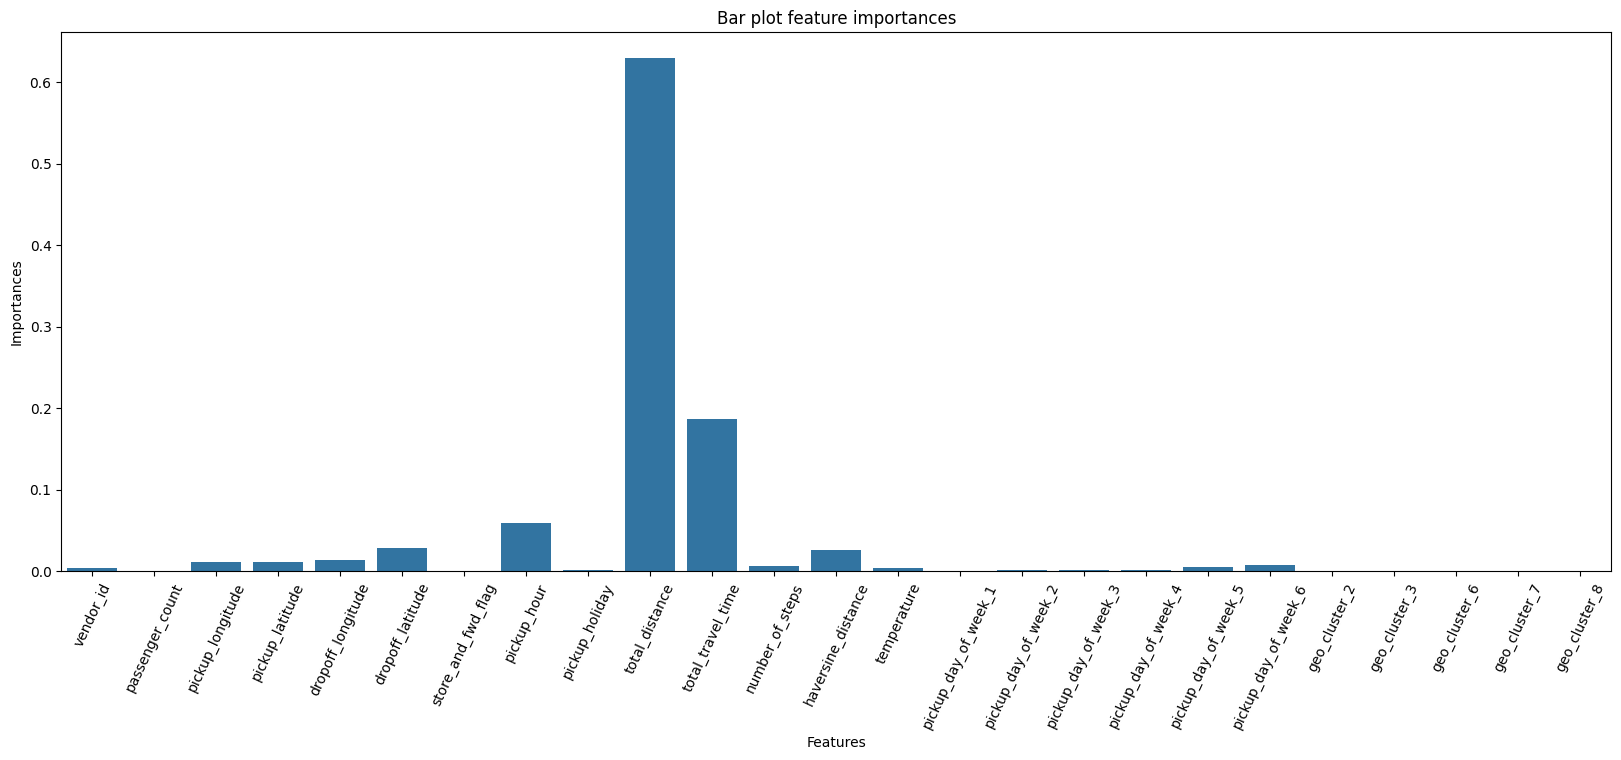

In [230]:
# Now let's look at the importance of the features
fig, ax = plt.subplots(figsize=(20, 7)) 
feature = X_train_scaled.columns 
feature_importances = model_GBR.feature_importances_ 

sns.barplot(x=feature, y=feature_importances, ax=ax);
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.xaxis.set_tick_params(rotation=65);

In [ ]:
# Now create a submission for the test data set
test_data = pd.read_csv("data/test.csv")
osrm_data_test = pd.read_csv("data/osrm_data_test.csv")
test_id = test_data['id']

test_data['pickup_datetime']=pd.to_datetime(test_data['pickup_datetime'],format='%Y-%m-%d %H:%M:%S')
test_data = add_datetime_features(test_data)
test_data = add_holiday_features(test_data, holiday_data)
test_data = add_osrm_features(test_data, osrm_data_test)
test_data = add_geographical_features(test_data)

# We create a training dataset from the geographical coordinates of all points
coords = np.hstack((test_data[['pickup_latitude', 'pickup_longitude']],
                    test_data[['dropoff_latitude', 'dropoff_longitude']]))

# Training the clustering algorithm
kmeans = cluster.KMeans(n_clusters=10, random_state=42)
kmeans.fit(coords)

test_data = add_cluster_features(test_data, kmeans)
test_data = add_weather_features(test_data, weather_data)
test_data = fill_null_weather_data (test_data)

test_data['vendor_id'] = test_data['vendor_id'].apply(lambda x: 0 if x == 1 else 1)
test_data['store_and_fwd_flag'] = test_data['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)
test_data_onehot = one_hot_encoder.fit_transform(test_data[one_hot_encoder_cols]).toarray()
column_names = one_hot_encoder.get_feature_names_out(one_hot_encoder_cols)
test_data_onehot = pd.DataFrame(test_data_onehot, columns=column_names)

test_data = pd.concat(
    [test_data.reset_index(drop=True).drop(one_hot_encoder_cols, axis=1), test_data_onehot], 
    axis=1
)

X_test = test_data[best_features]
X_test_scaled = MinMax_scaler.transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Make a prediction on the validation set
y_test_pred_log = model_GBR.predict(X_test_scaled)
y_test_predict = np.exp(y_test_pred_log) -1

submission = pd.DataFrame({'id': test_id, 'trip_duration': y_test_predict})
submission.to_csv('data/submission_gb.csv', index=False)